## The Advanced Computing Center for Research and Education

The Advanced Computing Center for Research and Education (ACCRE) is a computer cluster serving the high-performance computing needs of research for Vanderbilt University. In this data question, you will be analyzing data on jobs run on ACCRE's hardware.

The computing resources in the ACCRE cluster are divided into nodes. Each node is equipped with some number of CPUs, and some of the nodes contain GPUs (graphical processing units).  You have been provided a dataset, **accre-gpu-jobs-2022.csv**, which contains information on jobs submitted to ACCRE's GPU partitions. Traditionally GPUs were designed to power video games to perform calculations quickly. Because of the nature of their design, GPUs are being used more and more for non-graphics applications as well (e.g. for deep learning applications, molecular dynamics, image processing, and much more).

Recently, more researchers are performing work that requires GPU acceleration. Your task in this project is to analyze the GPU jobs that have been run on ACCRE over the last few years in order to better understand what needs to be provisioned moving forward. 

ACCRE has three scheduler partitions that groups can get access to which consist of machines each with 4 GPU cards. Each partition is named after the nvidia processor generation that it contains, from oldest to newest: maxwell, pascal, and turing. GPU nodes are requested per-GPU, and users can request up to 4 GPUs per node. For each GPU the user is allocated up to one quarter of the machine's RAM and CPU cores. All of the current GPU-accelerated hardware is also connected to a special high-speed RoCE (RDMA over converged ethernet) network allowing for memory sharing on large-scale multi-GPU jobs, so users can also request multiple servers for analysis that requires more than four GPU cards.

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
accre_df = pd.read_csv('../data/accre-gpu-jobs-2022-v2.csv', on_bad_lines='warn')

b'Skipping line 124084: expected 12 fields, saw 13\nSkipping line 124809: expected 12 fields, saw 13\n'


there are 2 bad lines, we'll ignore them for now...

In [3]:
accre_df.shape

(336950, 12)

Found this out later, the REQTIME, USEDTIME and USEDMEM are objects, have to remove junk and convert them:

In [4]:
accre_df['USEDMEM'] = accre_df['USEDMEM'].str.replace(r'M','', regex=True).astype(float)

accre_df['REQTIME'] = pd.to_timedelta(accre_df['REQTIME'].str.replace(r'-',' days ', regex=True))
accre_df['USEDTIME'] = pd.to_timedelta(accre_df['USEDTIME'].str.replace(r'-',' days ', regex=True))

We (pizza group) also decided to split up the dataframe. Dropping all of the running and pending jobs first (being 1258)

In [5]:
accre_df = accre_df[~accre_df['STATE'].isin(['RUNNING','PENDING'])]

up next, we decided to save the cancelled jobs in a separate dataframe. After that, just to make sure it contains only cancelled in various forms:

`pd.unique(accre_cancelled['STATE'])`

In [6]:
accre_cancelled = accre_df[~accre_df['STATE'].isin(['COMPLETED','FAILED','OUT_OF_MEMORY'])]

And finally, the dataframe that we will be using for most of our analysis (only status codes COMPLETED, FAILED or OUT OF MEMORY)

In [7]:
accre_df = accre_df[accre_df['STATE'].isin(['COMPLETED','FAILED','OUT_OF_MEMORY'])]

In [8]:
accre_df.shape

(283776, 12)

By doing all that, we got rid of 53174 rows!

### Onto some exploration regarding to the very first point

The main objectives of this project are to examine the following questions:
1. What is the distribution of per-GPU main memory usage over all runtime-weighed jobs in each partition? Knowing this will help ACCRE to understand our users memory needs for future hardware purchases.

We've actually done some of this analysis before; but after reformatting the notebook it's now here. How many jobs have used 0 memory (because they ran less than 2 min or otherwise):

`accre_df.groupby('USEDMEM').count()`

`accre_df[(accre_df['USEDMEM'] == '0') | (accre_df['USEDMEM'] == '0.00M')]`

Turns out that was 336950 jobs (0 or 0.00M)

In [9]:
accre_noM = accre_df[(accre_df['USEDMEM'] != '0') & (accre_df['USEDMEM'] != '0.00M')]

In [10]:
accre_noM.shape

(283776, 12)

After the cleanup from earlier, we only got rid of 5919 jobs here. That is important because some of them had runtimes which would affect the analysis. Initially did some additional exploration into various errors and codes; omitted here.

In [11]:
accre_noM[accre_noM['STATE'] == 'OUT_OF_MEMORY']

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
332639,46247498,glasshouse,tommie,138663.87,5 days 00:00:00,0 days 18:01:08,2,24,8,turing,0:125,OUT_OF_MEMORY
333434,46329470,pasilla,venus,7.19,0 days 00:30:00,0 days 00:05:05,1,1,1,turing,0:125,OUT_OF_MEMORY
334513,46514679,glasshouse,arnoldo,24221.36,0 days 04:00:00,0 days 01:11:23,1,6,1,turing,0:125,OUT_OF_MEMORY


kind of interesting that a job failed with only 7.19M usage and 5 minutes of run time.

In [12]:
accre_noM.groupby('NODES').count()

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,CPUS,GPUS,PARTITION,EXITCODE,STATE
NODES,,,,,,,,,,,
0,63,63,63,63,63,63,63,63,63,63,63
1,282887,282887,282887,282887,282887,282887,282887,282887,282887,282887,282887
2,330,330,330,330,330,330,330,330,330,330,330
3,363,363,363,363,363,363,363,363,363,363,363
4,48,48,48,48,48,48,48,48,48,48,48
5,57,57,57,57,57,57,57,57,57,57,57
6,8,8,8,8,8,8,8,8,8,8,8
7,12,12,12,12,12,12,12,12,12,12,12
9,1,1,1,1,1,1,1,1,1,1,1


In [13]:
accre_noM[accre_noM['NODES'] == 15]

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
62122,37020263,pasilla,dola,2.53,0 days 00:20:00,0 days 00:00:03,15,120,60,pascal,0:0,COMPLETED
270301,44976228,pasilla,dola,7.41,0 days 00:20:00,0 days 00:00:02,15,120,60,pascal,0:0,COMPLETED


Another interesting observation here that there were 2 jobs, from the same account and user who required 15 nodes (60) gpus; much more than anyone else!

Back to the question ... My understanding of the question 1) memory/gpu * time(job)/time(total)

In [14]:
accre_noM.groupby('PARTITION')['USEDTIME'].sum()

PARTITION
maxwell   2642 days 03:08:29
pascal    9780 days 21:19:05
turing    6407 days 15:58:37
Name: USEDTIME, dtype: timedelta64[ns]

In [15]:
accre_noM['TOT_USEDTIME_PART'] = accre_noM.groupby('PARTITION')['USEDTIME'].transform('sum').to_frame()

In [16]:
accre_noM['WEIGHTED_MEM_GPU'] = (
    (accre_noM['USEDMEM']/ accre_noM['GPUS']) *
    (accre_noM['USEDTIME']/accre_noM['TOT_USEDTIME_PART'])
)

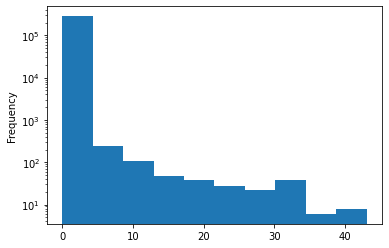

In [17]:
plt.axis
accre_noM['WEIGHTED_MEM_GPU'].plot(kind='hist', log='True');

Very heavy skew visible above -> meaning that most jobs take only a fraction of total time (per partition) and/or use very little memory. Let's compare partitions.

In [24]:
accre_noM.groupby('PARTITION')['WEIGHTED_MEM_GPU'].sum()

PARTITION
maxwell    2297.826032
pascal     2751.601922
turing     9277.105272
Name: WEIGHTED_MEM_GPU, dtype: float64

Even though more time (overall) was spent on Pascal than Turing, the memory usage of the latter one prevails. It's also interesting how close together Maxwell and Pascal are. Also, using the describe below, we can see how heavily the data is skewed.

In [23]:
accre_noM.groupby('PARTITION')['WEIGHTED_MEM_GPU'].describe()

,count,mean,std,min,25%,50%,75%,max
PARTITION,,,,,,,,
maxwell,127160.0,0.018070,0.477414,0.0,2.426843e-07,0.000904,0.001294,42.982171
pascal,81544.0,0.033744,0.379766,0.0,5.820515e-05,0.000834,0.002996,26.793911
turing,75072.0,0.123576,1.181682,0.0,1.873841e-07,0.000754,0.002275,43.074130


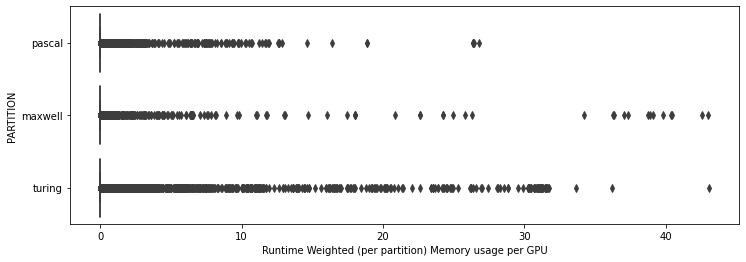

In [141]:
fig, ax = plt.subplots(figsize = (12,4))

sns.boxplot(
            data=accre_noM, 
            x='WEIGHTED_MEM_GPU', 
            y='PARTITION', 
            ax=ax
)
plt.xlabel('Runtime Weighted (per partition) Memory usage per GPU');

Lots of outliers!!! plotting below by not showing it:

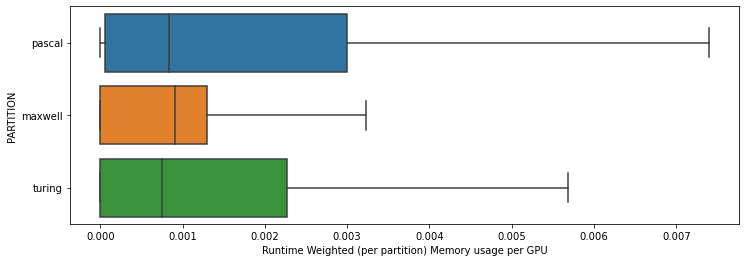

In [140]:
fig, ax = plt.subplots(figsize = (12,4))

sns.boxplot(
            data=accre_noM, 
            x='WEIGHTED_MEM_GPU', 
            y='PARTITION', 
            ax=ax,
            showfliers = False
)
plt.xlabel('Runtime Weighted (per partition) Memory usage per GPU');

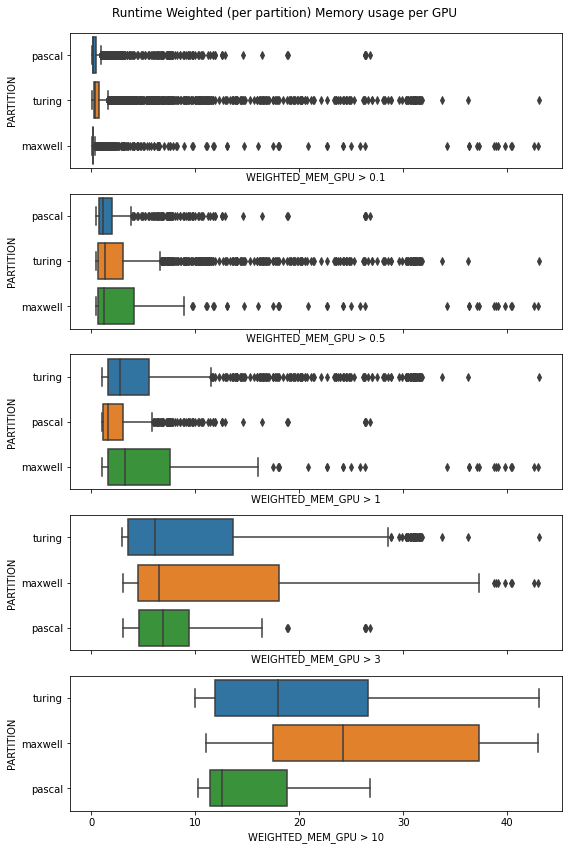

In [50]:
#Trying to plot the above by making cuts at different values
fig, axes = plt.subplots(5, sharex=True, figsize=(8, 12))
axes = axes.flatten()
fig.suptitle('Runtime Weighted (per partition) Memory usage per GPU')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>0.1], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[0]
)
axes[0].set_xlabel('WEIGHTED_MEM_GPU > 0.1')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>0.5], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[1]
)
axes[1].set_xlabel('WEIGHTED_MEM_GPU > 0.5')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>1], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[2]
)
axes[2].set_xlabel('WEIGHTED_MEM_GPU > 1')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>3], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[3]
)
axes[3].set_xlabel('WEIGHTED_MEM_GPU > 3')

ax = sns.boxplot(
        data=accre_noM.loc[accre_noM['WEIGHTED_MEM_GPU']>10], 
        x='WEIGHTED_MEM_GPU', 
        y='PARTITION',
        orient='h',
        ax=axes[4]
)
axes[4].set_xlabel('WEIGHTED_MEM_GPU > 10')

fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)

In [78]:
accre_df['DELTATIME'] = accre_df['REQTIME'] - accre_df['USEDTIME']

In [79]:
accre_df['REQSEC'] = [x.total_seconds() for x in accre_df['REQTIME']]
accre_df['USEDSEC'] = [x.total_seconds() for x in accre_df['USEDTIME']]
accre_df['DELTASEC'] = [x.total_seconds() for x in accre_df['DELTATIME']]

First off, with the code above, create new columns; one has the difference of time requested minus time used, the other three are converted in seconds.

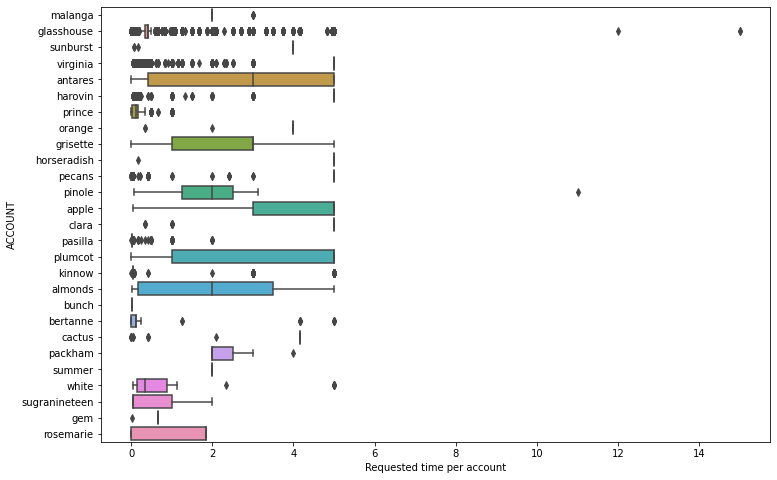

In [77]:
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(
            data=accre_df, 
            x=accre_df['REQSEC']/ 86400, 
            y='ACCOUNT', 
            ax=ax
)
plt.xlabel('Requested time (in days) per account');

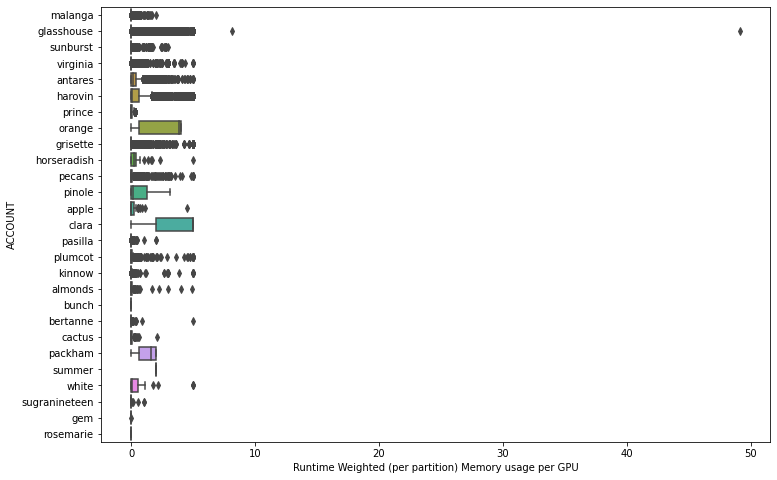

In [76]:
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(
            data=accre_df, 
            x=accre_df['USEDSEC']/ 86400, 
            y='ACCOUNT', 
            ax=ax
)
plt.xlabel('Used time (in days) per account');

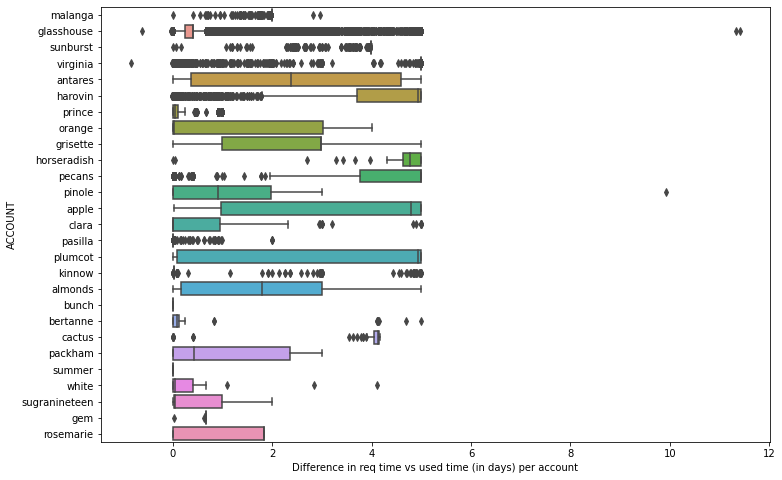

In [84]:
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(
            data=accre_df[accre_df['JOBID'] != '45364680'], #that job failed and ran for 50 days! 
            x=accre_df['DELTASEC']/ 86400, 
            y='ACCOUNT', 
            ax=ax
)
plt.xlabel('Difference in req time vs used time (in days) per account');

In [88]:
accre_df[accre_df['DELTASEC'] < 0].describe()

,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,REQSEC,USEDSEC,DELTATIME,DELTASEC
count,2914.000000,2914,2914,2914.000000,2914.000000,2914.000000,2914.000000,2.914000e+03,2914,2.914000e+03
mean,8759.580213,2 days 01:43:06.403568977,2 days 02:08:26.289636238,1.014756,4.070350,1.539121,178986.403569,1.805063e+05,-1 days +23:34:40.113932739,-1.519886e+03
std,29205.961130,2 days 02:13:56.424503923,2 days 06:24:11.700581402,0.199867,4.748844,1.578264,180836.424504,1.958517e+05,0 days 21:46:02.240706673,7.836224e+04
min,0.000000,0 days 00:01:00,0 days 00:01:01,1.000000,1.000000,1.000000,60.000000,6.100000e+01,-49 days +01:13:05,-4.229215e+06
25%,263.707500,0 days 04:00:00,0 days 04:00:04,1.000000,1.000000,1.000000,14400.000000,1.440400e+04,-1 days +23:59:34,-2.600000e+01
50%,2404.635000,1 days 00:00:00,1 days 00:00:29,1.000000,2.000000,1.000000,86400.000000,8.642900e+04,-1 days +23:59:41,-1.900000e+01
75%,5600.630000,5 days 00:00:00,5 days 00:00:03,1.000000,6.000000,1.000000,432000.000000,4.320030e+05,-1 days +23:59:50,-1.000000e+01
max,371247.350000,5 days 00:00:00,49 days 02:46:55,7.000000,60.000000,32.000000,432000.000000,4.243615e+06,-1 days +23:59:59,-1.000000e+00


In [145]:
accre_df[accre_df['DELTASEC'] <= 0].groupby(['PARTITION']).count().sort_values('JOBID', ascending=False)

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,EXITCODE,STATE,REQSEC,USEDSEC,DELTATIME,DELTASEC
PARTITION,,,,,,,,,,,,,,,
pascal,1756,1756,1756,1756,1756,1756,1756,1756,1756,1756,1756,1756,1756,1756,1756
turing,918,918,918,918,918,918,918,918,918,918,918,918,918,918,918
maxwell,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285


In [ ]:
1756 + 918 + 

Comment on above: there are 2914 jobs where the used time was more than requested. 285 in Maxwell, 1720 in pascal and 909 in turing. Above is also a breakdown per Account.

In [99]:
accre_df[accre_df['DELTASEC'] < -3600]

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,REQSEC,USEDSEC,DELTATIME,DELTASEC
65652,38189174,virginia,anitra,16709.34,2 days 00:00:00,2 days 20:03:53,1,12,2,turing,0:0,COMPLETED,172800.0,245033.0,-1 days +03:56:07,-72233.0
179215,44308490,glasshouse,minor,14203.65,0 days 16:00:00,1 days 06:57:20,1,6,1,turing,0:0,COMPLETED,57600.0,111440.0,-1 days +09:02:40,-53840.0
317705,45364680,glasshouse,daryl,0.00,0 days 04:00:00,49 days 02:46:55,1,2,1,pascal,0:0,FAILED,14400.0,4243615.0,-49 days +01:13:05,-4229215.0


Only 3 jobs go over an hour of requested time; two of which successfully completed. Lets now look at jobs that requested the max time of 5 days (excluding any exceptions over that).

In [103]:
accre_df.loc[accre_df['REQTIME'] == '5 days 00:00:00']

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,REQSEC,USEDSEC,DELTATIME,DELTASEC
327,32884086,glasshouse,miya,374.89,5 days,1 days 08:38:34,1,1,1,pascal,0:0,COMPLETED,432000.0,117514.0,3 days 15:21:26,314486.0
1063,32891995,glasshouse,erick,242.00,5 days,4 days 19:44:31,1,1,1,pascal,0:0,COMPLETED,432000.0,416671.0,0 days 04:15:29,15329.0
1064,32891996,glasshouse,erick,244.33,5 days,4 days 19:44:31,1,1,1,pascal,0:0,COMPLETED,432000.0,416671.0,0 days 04:15:29,15329.0
1065,32891997,glasshouse,erick,243.17,5 days,4 days 19:44:31,1,1,1,pascal,0:0,COMPLETED,432000.0,416671.0,0 days 04:15:29,15329.0
1066,32891998,glasshouse,erick,243.82,5 days,4 days 19:44:31,1,1,1,pascal,0:0,COMPLETED,432000.0,416671.0,0 days 04:15:29,15329.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336929,46753800,harovin,shannon,160.03,5 days,0 days 00:00:37,1,1,1,turing,0:0,COMPLETED,432000.0,37.0,4 days 23:59:23,431963.0
336933,46753813,harovin,shannon,137.96,5 days,0 days 00:00:52,1,1,1,turing,0:0,COMPLETED,432000.0,52.0,4 days 23:59:08,431948.0
336934,46753820_26,harovin,porsha,5093.70,5 days,0 days 00:34:51,1,6,1,turing,0:0,COMPLETED,432000.0,2091.0,4 days 23:25:09,429909.0
336936,46753823,harovin,shannon,156.21,5 days,0 days 00:04:03,1,1,1,turing,0:0,COMPLETED,432000.0,243.0,4 days 23:55:57,431757.0


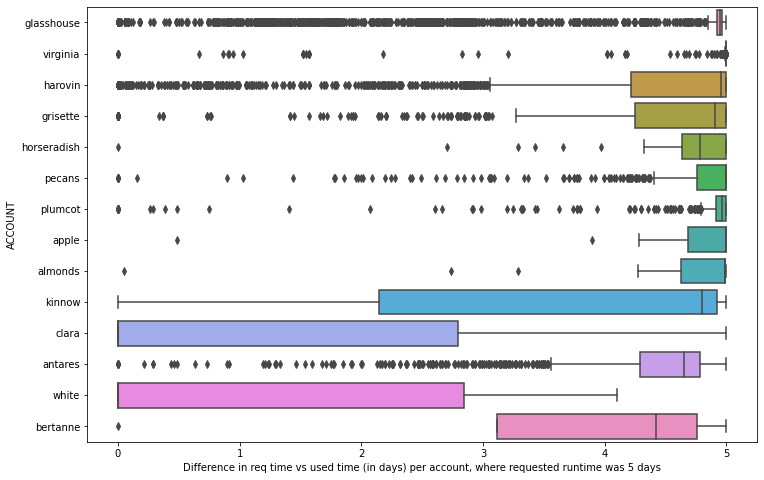

In [105]:
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(
            data=accre_df[accre_df['REQTIME'] == '5 days 00:00:00'], #that job failed and ran for 50 days! 
            x=accre_df['DELTASEC']/ 86400, 
            y='ACCOUNT', 
            ax=ax
)
plt.xlabel('Difference in req time vs used time (in days) per account, where requested runtime was 5 days');

To look at it better, how many of those accounts actually took at least 4 days to run? Or in other words, the time run was within 1 day of requested time.

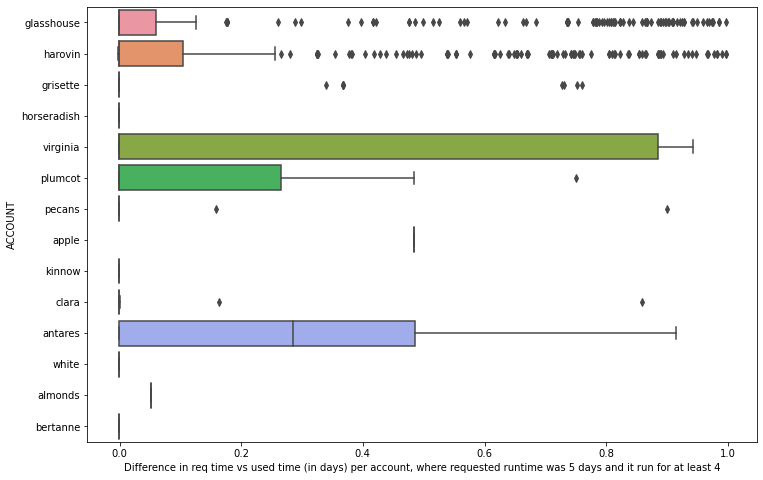

In [110]:
fig, ax = plt.subplots(figsize = (12,8))

sns.boxplot(
            data=accre_df[(accre_df['REQTIME'] == '5 days 00:00:00')
                          & (accre_df['DELTASEC']/ 86400 < 1)], #that job failed and ran for 50 days! 
            x=accre_df['DELTASEC']/ 86400, 
            y='ACCOUNT', 
            ax=ax
)
plt.xlabel('Difference in req time vs used time (in days) per account, where requested runtime was 5 days and it run for at least 4');

Let's explore just the ones that ran over.

In [117]:
accre_df[(accre_df['REQTIME'] == '5 days 00:00:00') & (accre_df['DELTASEC'] < 0)].sort_values('USEDTIME', ascending = False)

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,REQSEC,USEDSEC,DELTATIME,DELTASEC
330597,45754711_9,harovin,porsha,17932.89,5 days,5 days 00:04:26,1,6,1,turing,0:0,COMPLETED,432000.0,432266.0,-1 days +23:55:34,-266.0
330598,45754711_10,harovin,porsha,18744.37,5 days,5 days 00:04:25,1,6,1,turing,0:0,COMPLETED,432000.0,432265.0,-1 days +23:55:35,-265.0
59290,35860195,harovin,porsha,4045.17,5 days,5 days 00:02:24,1,3,1,turing,0:0,COMPLETED,432000.0,432144.0,-1 days +23:57:36,-144.0
59321,35863149,harovin,porsha,4550.14,5 days,5 days 00:01:21,1,3,1,turing,0:0,COMPLETED,432000.0,432081.0,-1 days +23:58:39,-81.0
60349,36303220_30,harovin,porsha,3938.44,5 days,5 days 00:01:14,1,3,1,turing,0:0,COMPLETED,432000.0,432074.0,-1 days +23:58:46,-74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332126,46043918_6,harovin,porsha,39056.30,5 days,5 days 00:00:01,1,6,1,turing,0:0,COMPLETED,432000.0,432001.0,-1 days +23:59:59,-1.0
71204,38951964,clara,suzanna,479.51,5 days,5 days 00:00:01,1,3,1,maxwell,0:0,COMPLETED,432000.0,432001.0,-1 days +23:59:59,-1.0
325645,45516891,glasshouse,jolette,299.33,5 days,5 days 00:00:01,1,1,1,pascal,0:0,COMPLETED,432000.0,432001.0,-1 days +23:59:59,-1.0
325650,45516896,glasshouse,jolette,300.01,5 days,5 days 00:00:01,1,1,1,pascal,0:0,COMPLETED,432000.0,432001.0,-1 days +23:59:59,-1.0


In [124]:
( accre_df
    [(accre_df['REQTIME'] == '5 days 00:00:00') & (accre_df['DELTASEC'] < 0)]
    .sort_values('USEDTIME', ascending = False)
    .groupby(['PARTITION','ACCOUNT', 'USER'])
    ['DELTASEC']
    .count()
)

PARTITION  ACCOUNT      USER     
maxwell    clara        suzanna       30
           glasshouse   erick         37
                        jolette       43
           plumcot      porsha         7
                        shannon        1
                        trevion        4
           white        brittani       3
pascal     antares      nakisha        7
           glasshouse   andra         27
                        birdella      16
                        collins        1
                        erick         10
                        jolette      166
                        jonnie        17
                        lea            3
           grisette     debera        12
                        hjalmar       11
                        kash           5
           horseradish  trudi          1
           kinnow       valentina      7
           pecans       glenda         2
                        nobie          6
           virginia     earlean        6
turing     bertanne    

In [126]:
( accre_df
    [(accre_df['REQTIME'] == '5 days 00:00:00') & (accre_df['DELTASEC'] < 0)]
    .groupby(['PARTITION','ACCOUNT', 'USER'])
    ['DELTASEC']
    .describe()
)

count       mean        std    min    25%  \
PARTITION ACCOUNT     USER                                                   
maxwell   clara       suzanna     30.0 -15.600000   8.896338  -28.0 -23.75   
          glasshouse  erick       37.0 -15.621622   5.633981  -29.0 -19.00   
                      jolette     43.0 -19.953488   4.745692  -23.0 -23.00   
          plumcot     porsha       7.0 -24.428571   5.094348  -32.0 -28.50   
                      shannon      1.0 -17.000000        NaN  -17.0 -17.00   
                      trevion      4.0 -10.000000   0.000000  -10.0 -10.00   
          white       brittani     3.0  -9.333333  10.115994  -21.0 -12.50   
pascal    antares     nakisha      7.0 -15.428571   9.947481  -28.0 -22.50   
          glasshouse  andra       27.0 -13.000000   9.085068  -30.0 -19.50   
                      birdella    16.0 -17.250000   8.858141  -32.0 -25.00   
                      collins      1.0  -4.000000        NaN   -4.0  -4.00   
                      erick       10.0 -11.700000   5.578729  -20.0 -15.00   
                      jolette    166.0 -14.590361   8.992975  -29.0 -23.00   
                      jonnie      17.0 -38.176471   8.323425  -53.0 -44.00   
                      lea          3.0 -23.333333  16.041613  -40.0 -31.00   
          grisette    debera      12.0 -14.666667   8.742096  -26.0 -24.00   
                      hjalmar     11.0 -21.818182   9.693484  -37.0 -29.00   
                      kash         5.0 -10.600000   9.289779  -25.0 -15.00   
          horseradish trudi        1.0 -13.000000        NaN  -13.0 -13.00   
          kinnow      valentina    7.0 -20.142857   9.281318  -29.0 -26.50   
          pecans      glenda       2.0 -19.000000  15.556349  -30.0 -24.50   
                      nobie        6.0 -13.666667  10.519823  -28.0 -22.00   
          virginia    earlean      6.0 -18.833333   7.884584  -27.0 -25.25   
turing    bertanne    vaughn       1.0  -7.000000        NaN   -7.0  -7.00   
          harovin     porsha     268.0 -22.638060  26.664646 -266.0 -27.00   
                      shannon     16.0 -16.937500   9.476066  -35.0 -22.25   
                      valentina   44.0 -14.136364   8.590397  -31.0 -22.00   

                                  50%    75%   max  
PARTITION ACCOUNT     USER                          
maxwell   clara       suzanna   -17.5  -7.00  -1.0  
          glasshouse  erick     -16.0 -16.00  -6.0  
                      jolette   -23.0 -16.00  -4.0  
          plumcot     porsha    -22.0 -20.00 -20.0  
                      shannon   -17.0 -17.00 -17.0  
                      trevion   -10.0 -10.00 -10.0  
          white       brittani   -4.0  -3.50  -3.0  
pascal    antares     nakisha   -16.0  -9.00  -1.0  
          glasshouse  andra     -10.0  -5.00  -2.0  
                      birdella  -14.0 -10.00  -7.0  
                      collins    -4.0  -4.00  -4.0  
                      erick     -15.0  -5.50  -5.0  
                      jolette   -13.5  -5.25  -1.0  
                      jonnie    -35.0 -33.00 -27.0  
                      lea       -22.0 -15.00  -8.0  
          grisette    debera    -15.5  -6.00  -2.0  
                      hjalmar   -22.0 -15.00  -4.0  
                      kash       -5.0  -4.00  -4.0  
          horseradish trudi     -13.0 -13.00 -13.0  
          kinnow      valentina -25.0 -14.50  -5.0  
          pecans      glenda    -19.0 -13.50  -8.0  
                      nobie      -9.0  -5.75  -5.0  
          virginia    earlean   -20.5 -12.00  -9.0  
turing    bertanne    vaughn     -7.0  -7.00  -7.0  
          harovin     porsha    -18.5  -9.75  -1.0  
                      shannon   -15.5 -13.25  -2.0  
                      valentina -14.5  -6.00  -3.0

looking at the numbers above it becomes clear that even the jobs that ran for 5 days went only a few minutes over.

In [134]:
accre_df.groupby(['PARTITION', 'ACCOUNT']).max('USEDMEM').sort_values('USEDMEM', ascending=False)

USEDMEM  NODES  CPUS  GPUS     REQSEC    USEDSEC  \
PARTITION ACCOUNT                                                             
turing    virginia       371247.35      1    24     4   432000.0   374580.0   
          glasshouse     310280.90      5    69    20   432000.0   377214.0   
pascal    virginia       248467.89      1     8     4   432000.0   432027.0   
          glasshouse     246085.25      7    49    32  1036800.0  4243615.0   
turing    pinole         184807.43      1    12     2   950400.0   270029.0   
          pasilla        176687.27     10    80    40   172800.0    86417.0   
maxwell   orange         119399.18      1    12     4   345600.0   345671.0   
          glasshouse     108395.95      9    70    30  1296000.0   432029.0   
turing    harovin        101567.61      2    12     2   432000.0   432266.0   
pascal    prince          61376.49      2     4     4    86400.0    28296.0   
turing    almonds         54002.86      1    24     4   432000.0   427462.0   
pascal    grisette        52411.83      1     2     2   432000.0   432037.0   
turing    apple           39202.25      4    16    16   432000.0   390205.0   
pascal    pecans          38455.00      2     2     2   432000.0   432030.0   
maxwell   plumcot         32551.93      1     4     2   432000.0   432032.0   
pascal    kinnow          32061.38      1     2     1   432000.0   432029.0   
          horseradish     19190.83      1     4     2   432000.0   432013.0   
turing    bertanne        15361.43      3    72    12   432000.0   432007.0   
pascal    antares         12762.71      1     2     1   432000.0   432028.0   
turing    gem             12139.35      1     6     1    57600.0     2428.0   
pascal    sunburst        11327.27      1     2     2   345600.0   253741.0   
maxwell   bertanne        10083.02      1     4     1   108000.0    35584.0   
pascal    packham          9042.00      1     4     2   345600.0   172823.0   
turing    cactus           8912.46      4    20     8   360000.0   180003.0   
pascal    rosemarie        8283.96      2     2     2   158400.0      968.0   
          malanga          7572.38      1     2     1   259200.0   172829.0   
turing    prince           6663.11      1     6     1    14400.0    13447.0   
          antares          5862.57      1     2     1   172800.0    51664.0   
maxwell   pasilla          5612.62     10    80    40   172800.0     3627.0   
          white            4944.60      1    12     4   432000.0   432021.0   
pascal    bertanne         2583.11      1     1     2     7200.0     3182.0   
maxwell   clara             638.61      2     3     4   432000.0   432028.0   
turing    sugranineteen     421.18      1     6     1   172800.0    86426.0   
pascal    pasilla           120.90     15   120    60   172800.0   172816.0   
maxwell   summer             92.66      1     6     2   172800.0   172817.0   
turing    bunch               6.09      1     1     1     1200.0      754.0   

                         DELTASEC  
PARTITION ACCOUNT                  
turing    virginia       431995.0  
          glasshouse     431997.0  
pascal    virginia       431993.0  
          glasshouse     432000.0  
turing    pinole         857046.0  
          pasilla        172414.0  
maxwell   orange         345512.0  
          glasshouse     985570.0  
turing    harovin        432000.0  
pascal    prince          85148.0  
turing    almonds        431658.0  
pascal    grisette       431996.0  
turing    apple          432000.0  
pascal    pecans         432000.0  
maxwell   plumcot        431996.0  
pascal    kinnow         431962.0  
          horseradish    431995.0  
turing    bertanne       431603.0  
pascal    antares        431969.0  
turing    gem             57587.0  
pascal    sunburst       345600.0  
maxwell   bertanne        72508.0  
pascal    packham        259181.0  
turing    cactus         359997.0  
pascal    rosemarie      157979.0  
          malanga        256181.0  
turing    prince

Now looking into the GPU usage

In [135]:
accre_df.groupby(['PARTITION', 'ACCOUNT']).max('GPUS').sort_values('GPUS', ascending=False)

USEDMEM  NODES  CPUS  GPUS     REQSEC    USEDSEC  \
PARTITION ACCOUNT                                                             
pascal    pasilla           120.90     15   120    60   172800.0   172816.0   
turing    pasilla        176687.27     10    80    40   172800.0    86417.0   
maxwell   pasilla          5612.62     10    80    40   172800.0     3627.0   
pascal    glasshouse     246085.25      7    49    32  1036800.0  4243615.0   
maxwell   glasshouse     108395.95      9    70    30  1296000.0   432029.0   
turing    glasshouse     310280.90      5    69    20   432000.0   377214.0   
          apple           39202.25      4    16    16   432000.0   390205.0   
          bertanne        15361.43      3    72    12   432000.0   432007.0   
          cactus           8912.46      4    20     8   360000.0   180003.0   
pascal    prince          61376.49      2     4     4    86400.0    28296.0   
turing    almonds         54002.86      1    24     4   432000.0   427462.0   
pascal    virginia       248467.89      1     8     4   432000.0   432027.0   
maxwell   clara             638.61      2     3     4   432000.0   432028.0   
turing    virginia       371247.35      1    24     4   432000.0   374580.0   
maxwell   white            4944.60      1    12     4   432000.0   432021.0   
          orange         119399.18      1    12     4   345600.0   345671.0   
          plumcot         32551.93      1     4     2   432000.0   432032.0   
pascal    pecans          38455.00      2     2     2   432000.0   432030.0   
          horseradish     19190.83      1     4     2   432000.0   432013.0   
          rosemarie        8283.96      2     2     2   158400.0      968.0   
          sunburst        11327.27      1     2     2   345600.0   253741.0   
          grisette        52411.83      1     2     2   432000.0   432037.0   
          bertanne         2583.11      1     1     2     7200.0     3182.0   
turing    pinole         184807.43      1    12     2   950400.0   270029.0   
pascal    packham          9042.00      1     4     2   345600.0   172823.0   
maxwell   summer             92.66      1     6     2   172800.0   172817.0   
turing    harovin        101567.61      2    12     2   432000.0   432266.0   
          sugranineteen     421.18      1     6     1   172800.0    86426.0   
          prince           6663.11      1     6     1    14400.0    13447.0   
pascal    malanga          7572.38      1     2     1   259200.0   172829.0   
turing    gem             12139.35      1     6     1    57600.0     2428.0   
          bunch               6.09      1     1     1     1200.0      754.0   
pascal    antares         12762.71      1     2     1   432000.0   432028.0   
turing    antares          5862.57      1     2     1   172800.0    51664.0   
pascal    kinnow          32061.38      1     2     1   432000.0   432029.0   
maxwell   bertanne        10083.02      1     4     1   108000.0    35584.0   

                         DELTASEC  
PARTITION ACCOUNT                  
pascal    pasilla         14293.0  
turing    pasilla        172414.0  
maxwell   pasilla        172423.0  
pascal    glasshouse     432000.0  
maxwell   glasshouse     985570.0  
turing    glasshouse     431997.0  
          apple          432000.0  
          bertanne       431603.0  
          cactus         359997.0  
pascal    prince          85148.0  
turing    almonds        431658.0  
pascal    virginia       431993.0  
maxwell   clara          431996.0  
turing    virginia       431995.0  
maxwell   white          354666.0  
          orange         345512.0  
          plumcot        431996.0  
pascal    pecans         432000.0  
          horseradish    431995.0  
          rosemarie      157979.0  
          sunburst       345600.0  
          grisette       431996.0  
          bertanne         7197.0  
turing    pinole         857046.0  
pascal    packham        259181.0  
maxwell   summer            -17.0  
turing    harovi

In [138]:
accre_df.groupby(['PARTITION', 'GPUS']).count()

JOBID  ACCOUNT    USER  USEDMEM  REQTIME  USEDTIME   NODES  \
PARTITION GPUS                                                                
maxwell   1     124897   124897  124897   124897   124897    124897  124897   
          2       1501     1501    1501     1501     1501      1501    1501   
          3         13       13      13       13       13        13      13   
          4        316      316     316      316      316       316     316   
          6         51       51      51       51       51        51      51   
          8        139      139     139      139      139       139     139   
          12       198      198     198      198      198       198     198   
          16        32       32      32       32       32        32      32   
          18         6        6       6        6        6         6       6   
          20         1        1       1        1        1         1       1   
          24         3        3       3        3        3         3       3   
          30         1        1       1        1        1         1       1   
          40         2        2       2        2        2         2       2   
pascal    1      76625    76625   76625    76625    76625     76625   76625   
          2       3417     3417    3417     3417     3417      3417    3417   
          3         10       10      10       10       10        10      10   
          4        877      877     877      877      877       877     877   
          8        272      272     272      272      272       272     272   
          12         7        7       7        7        7         7       7   
          16       267      267     267      267      267       267     267   
          24        58       58      58       58       58        58      58   
          32         9        9       9        9        9         9       9   
          60         2        2       2        2        2         2       2   
turing    1      73483    73483   73483    73483    73483     73483   73483   
          2        569      569     569      569      569       569     569   
          3         88       88      88       88       88        88      88   
          4        663      663     663      663      663       663     663   
          8        241      241     241      241      241       241     241   
          12         3        3       3        3        3         3       3   
          16        21       21      21       21       21        21      21   
          20         1        1       1        1        1         1       1   
          40         3        3       3        3        3         3       3   

                  CPUS  EXITCODE   STATE  REQSEC  USEDSEC  DELTATIME  DELTASEC  
PARTITION GPUS                                                                  
maxwell   1     124897    124897  124897  124897   124897     124897    124897  
          2       1501      1501    1501    1501     1501       1501      1501  
          3         13        13      13      13       13         13        13  
          4        316       316     316     316      316        316       316  
          6         51        51      51      51       51         51        51  
          8        139       139     139     139      139        139       139  
          12       198       198     198     198      198        198       198  
          16        32        32      32      32       32         32        32  
          18         6         6       6       6        6          6         6  
          20         1         1       1       1        1          1         1  
          24         3         3       3       3        3          3         3  
          30         1         1       1       1        1          1         1  
          40         2         2       2       2        2          2         2  
pascal    1      76625     76625   76625   76625    76625      76625     76625  
          2       3417      3417  

In [139]:
accre_df[accre_df['GPUS'] != 1].groupby(['PARTITION', 'GPUS']).count()

JOBID  ACCOUNT  USER  USEDMEM  REQTIME  USEDTIME  NODES  CPUS  \
PARTITION GPUS                                                                  
maxwell   2      1501     1501  1501     1501     1501      1501   1501  1501   
          3        13       13    13       13       13        13     13    13   
          4       316      316   316      316      316       316    316   316   
          6        51       51    51       51       51        51     51    51   
          8       139      139   139      139      139       139    139   139   
          12      198      198   198      198      198       198    198   198   
          16       32       32    32       32       32        32     32    32   
          18        6        6     6        6        6         6      6     6   
          20        1        1     1        1        1         1      1     1   
          24        3        3     3        3        3         3      3     3   
          30        1        1     1        1        1         1      1     1   
          40        2        2     2        2        2         2      2     2   
pascal    2      3417     3417  3417     3417     3417      3417   3417  3417   
          3        10       10    10       10       10        10     10    10   
          4       877      877   877      877      877       877    877   877   
          8       272      272   272      272      272       272    272   272   
          12        7        7     7        7        7         7      7     7   
          16      267      267   267      267      267       267    267   267   
          24       58       58    58       58       58        58     58    58   
          32        9        9     9        9        9         9      9     9   
          60        2        2     2        2        2         2      2     2   
turing    2       569      569   569      569      569       569    569   569   
          3        88       88    88       88       88        88     88    88   
          4       663      663   663      663      663       663    663   663   
          8       241      241   241      241      241       241    241   241   
          12        3        3     3        3        3         3      3     3   
          16       21       21    21       21       21        21     21    21   
          20        1        1     1        1        1         1      1     1   
          40        3        3     3        3        3         3      3     3   

                EXITCODE  STATE  REQSEC  USEDSEC  DELTATIME  DELTASEC  
PARTITION GPUS                                                         
maxwell   2         1501   1501    1501     1501       1501      1501  
          3           13     13      13       13         13        13  
          4          316    316     316      316        316       316  
          6           51     51      51       51         51        51  
          8          139    139     139      139        139       139  
          12         198    198     198      198        198       198  
          16          32     32      32       32         32        32  
          18           6      6       6        6          6         6  
          20           1      1       1        1          1         1  
          24           3      3       3        3          3         3  
          30           1      1       1        1          1         1  
          40           2      2       2        2          2         2  
pascal    2         3417   3417    3417     3417       3417      3417  
          3           10     10      10       10         10        10  
          4          877    877     877      877        877       877  
          8          272    272     272      272        272       272  
          12           7      7       7        7          7         7  
          16         267    267     267      267        267       267  
          24          58     58      58       58         58     

2. What is the distribution of the number of GPUs in each job (runtime-weighted) for each partition? What fraction of runtime-weighted and GPU-weighted jobs are using more than 4 GPUs and thus probably using the RoCE networking? Is this fraction different for each partition?

3. What is the total runtime usage per-gpu (i.e. multiply runtime by the number of gpus) in each of the 3 partitions over the last year?

4. What is the distribution of different groups and users accessing each partition? In each partition, who are the top users, and do they represent a majority of the runtime-weighted jobs on the partition?

5. Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?